<h3 style="text-align:center">
    In the name of God
</h3>
<p style="text-align:left">
    Machine Learning Course 1400, Dr. Sajedi
    <br>HW2
    <br>Alireza Kazemipour
    <br>610300171
</p>

In [1]:
!pip install nn-without-frameworks

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%matplotlib inline

from nn_without_frameworks import numpy_nn as nn
from typing import List
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
dataset = pd.read_csv('pd_speech_features.csv', skiprows=[0], encoding="utf-8")
print(dataset.keys())

Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)


In [3]:
dataset_vals = dataset.values
X = dataset_vals[..., :-1]
Y = dataset_vals[..., -1]
n_class = int(np.max(Y) + 1)
n_feat = X.shape[-1]
print(f"input's shape: {X.shape}")
print(f"labels's shape: {Y.shape}")

input's shape: (756, 754)
labels's shape: (756,)


In [4]:
cv_num = 5
seed = 123

In [5]:
np.random.seed(seed)
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

In [6]:
test_idx = np.random.permutation(int(0.1 * len(X)))
x_test = X[test_idx]
y_test = Y[test_idx]

X = np.delete(X, test_idx, axis=0)
Y = np.delete(Y, test_idx, axis=0)
full_batch_size = X.shape[0]

In [7]:
scaler = StandardScaler() 
X = scaler.fit_transform(X)

In [8]:
def choose_fold(x, y, n):
    for i in range(n):
        x_val = x[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]
        y_val = y[i * full_batch_size // cv_num: (i + 1) * full_batch_size // cv_num]

        x_train = np.delete(x, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)
        y_train = np.delete(y, range(i * full_batch_size // cv_num, (i + 1) * full_batch_size // cv_num), axis=0)

        yield x_train, y_train, x_val, y_val

In [49]:
class NNClassifier:
    def __init__(self,
                 hidden_units: List=[64],
                 epoch=500,
                 lr=0.001,
                 opt: nn.optims.Optimizer=nn.optims.SGD,
                 lam: float=0,
                 reg_type: str=None
                ):
        self.hidden_units = hidden_units
        self.epoch = epoch
        self.lr = lr
        self.opt = opt
        self.lam = lam
        self.reg_type = reg_type
        self.bce_loss = nn.losses.BinaryCrossEntropy()
        self.model = None
        self.loss_history = []
        
    def fit(self, x, y):
        self.loss_history = []
        if self.model is None:
            n_feats = int(x.shape[-1])
            self.hidden_units.insert(0, n_feat)
            
            hidden_layers = []
            for i in range(len(self.hidden_units) - 1):
                hidden_layers.append(nn.layers.Dense(in_features=self.hidden_units[i],
                                           out_features=self.hidden_units[i+1],
                                           activation=nn.acts.ReLU(),
                                           weight_initializer=nn.inits.HeNormal(nn.acts.ReLU()),
                                           bias_initializer=nn.inits.Constant(0.01),
                                           regularizer_type=self.reg_type,
                                           lam=self.lam)
                                    )
                hidden_layers.append(nn.layers.BatchNorm1d(self.hidden_units[i+1])) 
            output_layer = nn.layers.Dense(in_features=self.hidden_units[-1],
                                      out_features=1,
                                      activation=nn.acts.Sigmoid(),
                                      weight_initializer=nn.inits.XavierUniform(),
                                      bias_initializer=nn.inits.Constant(0.01),
                                      regularizer_type=self.reg_type,
                                      lam=self.lam)
            
            self.model = nn.Sequential(*hidden_layers, output_layer)
            self.opt = self.opt(self.model.parameters, lr=self.lr)
            
        for step in range(self.epoch):
            y_pred = self.model(x)
            y_pred = y_pred.squeeze(-1)
            loss = self.bce_loss(y_pred, y)
            self.model.backward(loss)
            self.opt.apply()
            if step == 0:
                self.loss_history.append(loss.value)
            else:
                self.loss_history.append(0.9 * self.loss_history[-1] + 0.1 * loss.value)
            
    def predict(self, x):
        assert not self.model is None
        pred = self.model(x)
        return np.where(pred > 0.5, 1, 0).squeeze(-1)
    
    def model_architecture(self):
        self.model.summary() 

In [52]:
clfs = {"Neural Net": {"base_clf": NNClassifier(hidden_units=[64],
                                                epoch=600,
                                                opt=nn.optims.Adam,
                                                lam=1e-3,
                                                reg_type="l2"
                                               ),
                       "param": "lr",
                       "param_values": [1e-3, 1e-4, 1e-5]
                       }
        }

100%|█████████████████████████████████████████████| 3/3 [01:07<00:00, 22.51s/it]

==> Neural Net <==
Training result:
	best param: lr = 0.0001
	best validation accuracy = 81.63%


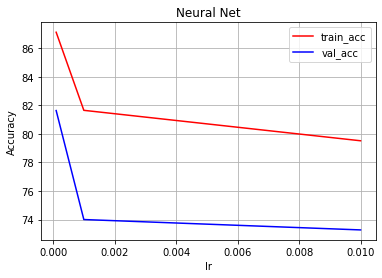


Model Summary:
+----------------+----------------+----------+
| Layer          | Output shape   |   Param# |
+================+================+==========+
| Input          | (None, 754)    |        0 |
+----------------+----------------+----------+
| Dense[0]       | (None, 64)     |    48320 |
+----------------+----------------+----------+
| BatchNorm1d[1] | (None, 64)     |      128 |
+----------------+----------------+----------+
| Dense[2]       | (None, 1)      |       65 |
+----------------+----------------+----------+


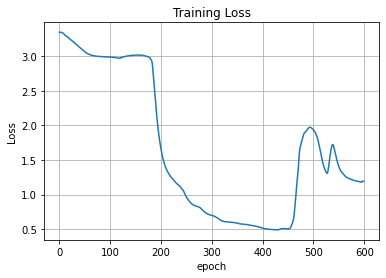

Test result: 


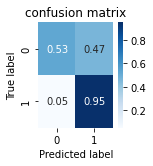

              precision    recall  f1-score   support

         0.0       0.77      0.53      0.62        19
         1.0       0.85      0.95      0.90        56

    accuracy                           0.84        75
   macro avg       0.81      0.74      0.76        75
weighted avg       0.83      0.84      0.83        75


🎁🎁🎁best_model is: Neural Net with test acc = 84.00%.


In [53]:
best_test_acc = -np.inf
best_model = {}

for clf_name, config in clfs.items():
    history = {"train_acc": [], "val_acc": []}
    best_val_acc = 0
    best_param = None

    for p in tqdm(config["param_values"]):
        avg_val_acc = 0
        avg_train_acc = 0

        for x_train, y_train, x_val, y_val in choose_fold(X, Y, cv_num):
            clf = config["base_clf"]
            setattr(clf, config["param"], p)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_train)
            avg_train_acc += (np.sum(y_pred == y_train) / len(y_pred)) * 100
            y_pred = clf.predict(x_val)
            avg_val_acc += (np.sum(y_pred == y_val) / len(y_pred)) * 100

        history["train_acc"].append(avg_train_acc / cv_num)
        history["val_acc"].append(avg_val_acc / cv_num)

        if history["val_acc"][-1] > best_val_acc:
            best_val_acc = history["val_acc"][-1]
            best_param = p
            if clf_name == "Neural Net":
                best_loss_hist = clf.loss_history

    print(f"==> {clf_name} <==")
    print("Training result:")
    print("\tbest param: {} = {}\n\tbest validation accuracy = {:.2f}%".format(config["param"],
                                                                               best_param,
                                                                               best_val_acc))        
    plt.plot(config["param_values"], history["train_acc"], c="r")
    plt.plot(config["param_values"], history["val_acc"], c="b")
    plt.legend(history.keys())
    plt.grid()
    plt.title(clf_name)
    plt.ylabel("Accuracy")
    plt.xlabel(config["param"])
    if "SVM" in clf_name or clf_name == "XGBoost":
        plt.xscale("log")
    plt.show()
    
    if clf_name == "Neural Net":
        clf.model_architecture()
        plt.plot()
        plt.plot(range(clf.epoch), best_loss_hist)
        plt.grid()
        plt.title("Training Loss")
        plt.ylabel("Loss")
        plt.xlabel("epoch")
        plt.show()
        
    print("Test result: ")
    setattr(clf, config["param"], best_param)
    clf.fit(X, Y)
    x_test_stand = scaler.transform(x_test)
    y_pred = clf.predict(x_test_stand)
    test_acc = (np.sum(y_pred == y_test) / len(y_pred)) * 100
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model["name"] = clf_name
        best_model["clf"] = clf
    con_mat = confusion_matrix(y_test, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=[i for i in range(n_class)], columns=[i for i in range(n_class)])
    figure = plt.figure(figsize=(n_class, n_class))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    report = classification_report(y_test, y_pred)
    print(report)

    if clf_name == "Decision Tree":
        setattr(clfs["Random Forest"]["base_clf"], "max_depth", best_param)
        setattr(clfs["XGBoost"]["base_clf"], "max_depth", best_param)

    if clf_name == "Random Forest":
        setattr(clfs["XGBoost"]["base_clf"], "n_estimators", best_param)
        
print(f"\n🎁🎁🎁best_model is: {best_model['name']} with test acc = {best_test_acc:.2f}%.")